### Importing packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from difflib import SequenceMatcher, get_close_matches
import re
from tqdm import tqdm, trange
import time

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [2]:
products_df = pd.read_csv('/home/natasha/Documents/Iprocure/Clustering-for-Product-Matching/data/data_v2/subsequent_unmatched_products.csv')
products_df = products_df[:100000]

In [3]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   product_name         100000 non-null  object 
 1   best_product_match   100000 non-null  object 
 2   product_match_score  100000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB


### Data Preprocessing

In [4]:
# changing all strings to lowercase
products_df = products_df.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)
products_df.head()

,product_name,best_product_match,product_match_score
0,capacitor,plantector,0.42
1,starter crumbs fugo,broiler starter crumbs,0.68
2,rewinding 1hp induction geared motor,biodistinction extra,0.36
3,pizza small chopping board,dairy meal economy okoa,0.49
4,bamboo chopping bord,choline chloride,0.39


In [5]:
products_df['product_name'].nunique()

12543

In [6]:
# filtering for unique product names
unique_product_names = products_df['product_name'].unique()
len(unique_product_names)

12543

### Clustering

In [7]:
sample_1 = unique_product_names[:1000]
len(sample_1)

1000

In [8]:
# vectorizing the product names
vectorizer = TfidfVectorizer()
tfidf_matrix_1 = vectorizer.fit_transform(sample_1)

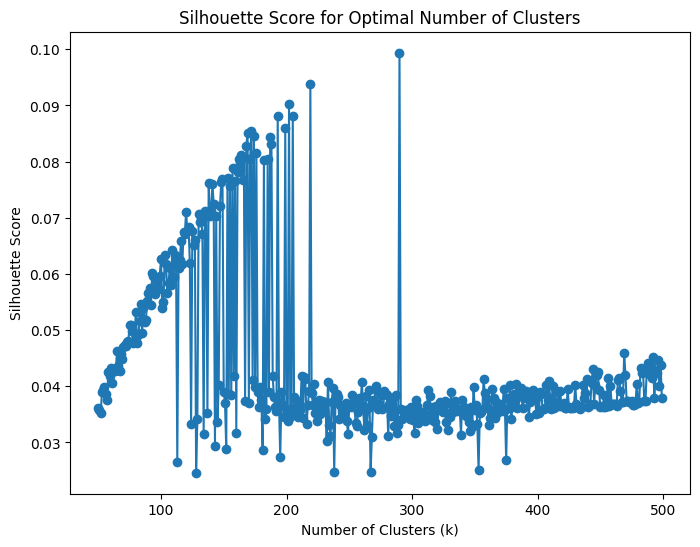

The best number of clusters (k) based on silhouette score is: 290


In [12]:
# Silhouette scores
silhouette_scores = []

# Number of clusters to try
k_values = range(50, 500)

# Perform k-means clustering for different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix_1)
    
    silhouette_avg = silhouette_score(tfidf_matrix_1, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Find the best number of clusters
best_k = k_values[np.argmax(silhouette_scores)]
print(f'The best number of clusters (k) based on silhouette score is: {best_k}')


In [9]:
# clustering the data
num_clusters = 290
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(tfidf_matrix_1)
labels = kmeans.labels_

# creating a dataframe of the clusters
cluster_to_name = {}
for label in set(labels):
    indices = np.where(labels == label)[0]
    names = unique_product_names[indices].tolist()
    cluster_to_name[label] = names
    
# viewing the clusters
cluster_1_df = pd.DataFrame.from_dict(cluster_to_name.items())
cluster_1_df.rename(columns={0: 'cluster_id', 1: 'product_names'}, inplace=True)
cluster_1_df.set_index('cluster_id', inplace=True)
pd.set_option('display.max_colwidth', None)
cluster_1_df.head(5)

,product_names
cluster_id,
0,"[pregnacy rapid test, laborex pregnacy test]"
1,"[left(cp/tg) clutchlever{011}, cp/tg)ord(left) (m.h)mirrorholder(012), cp/tg(right)ord(m.h) mirrorholder(010)]"
2,"[2t, white ug (white m germ), k-lube(white) 2t(oil), totalspecial(2t) oil(strock)powersaw]"
3,"[fedozinon 50ec. dawa ya mende na kunguni, fedozinon diazinon, dawa ya kuku, fedozinon (dawa ya kunguni), albedose dawa ya njau]"
4,"[hogobosperfume@30, fulani ezbraid ""26"" no. 30/27p, cellotape medium(30), onemillionperfume@30]"


In [10]:
sample_2 = unique_product_names[:1020]
len(sample_2)

1020

In [11]:
# vectorizing the product names
vectorizer = TfidfVectorizer()
tfidf_matrix_2 = vectorizer.fit_transform(sample_2)

In [12]:
# clustering the data
num_clusters = 290
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(tfidf_matrix_2)
labels = kmeans.labels_

# creating a dataframe of the clusters
cluster_to_name = {}
for label in set(labels):
    indices = np.where(labels == label)[0]
    names = unique_product_names[indices].tolist()
    cluster_to_name[label] = names
    
# viewing the clusters
cluster_2_df = pd.DataFrame.from_dict(cluster_to_name.items())
cluster_2_df.rename(columns={0: 'cluster_id', 1: 'product_names'}, inplace=True)
cluster_2_df.set_index('cluster_id', inplace=True)
pd.set_option('display.max_colwidth', None)
cluster_2_df.head(5)

,product_names
cluster_id,
0,[pen crown matrix]
1,[bm150/tvsstar/max speedcable(org)]
2,"[agycin 500mg(azithromycin), azithromycin tab 500mg(zerocin), azithromycin(agycin), agycin 250-azithromycin, azithromycin(zithrox)500mg]"
3,"[1""no.13(both) bolt&nuts, ¾/1""no.12/13 bolt(h10)]"
4,"[gunia empty 50kg, gunia(empty)]"


In [17]:
search_item = 'pregnacy rapid test'
filtered_rows = cluster_2_df[cluster_2_df['product_names'].apply(lambda x: any(search_item in item for item in x))]
filtered_rows


,product_names
cluster_id,
146,"[pregnacy rapid test, laborex pregnacy test]"


In [19]:
cluster_1_df['cluster_size'] = cluster_1_df['product_names'].apply(lambda x: len(x))
cluster_1_df[cluster_1_df['cluster_size'] == 1]

,product_names,cluster_size
cluster_id,,
1,[dog chain big],1
5,[coco clear lightening cream 140 ml],1
15,[shinery/cp(green)(s.c) sidecover056],1
42,[single holed nozzle],1
77,[richa maize germ],1
129,[exhaust bolt(no.10)],1
166,"[ppr male tee ½""]",1
192,[24d amine bukoola 500ml],1
215,[coconut oil forever],1


In [20]:
unique_names_df = pd.DataFrame({'product_name': unique_product_names,
                                'label': labels})
unique_names_df.head()
len(unique_names_df)

12543

### Topic Modeling

In [18]:
# # extracting most common words from each cluster in order
# cluster_word_freq = {}

# for doc, cluster_label in zip(unique_product_names, labels):
#     words = re.split(r'\s+|-|\(|\)|/|\\|\||,', doc)
#     for word in words:
#         if cluster_label in cluster_word_freq:
#             cluster_word_freq[cluster_label][word] = cluster_word_freq[cluster_label].get(word, 0) + 1
#         else:
#             cluster_word_freq[cluster_label] = {word: 1}
    
# for cluster_label in cluster_word_freq:
#     cluster_word_freq[cluster_label] = sorted(cluster_word_freq[cluster_label].items(), key=lambda x: x[1], reverse=True)
    
# cluster_word_freq_df = pd.DataFrame.from_dict(cluster_word_freq.items())
# cluster_word_freq_df.rename(columns={0: 'cluster_id', 1: 'word_freq'}, inplace=True)
# cluster_word_freq_df.head()

,cluster_id,word_freq
0,7273,"[(capacitor, 2), (200, 1)]"
1,2180,"[(crumbs, 7), (fugo, 7), (starter, 6), (, 5), (50kg, 2), (10kg, 1), (25kg, 1), (1kg, 1)]"
2,8491,"[(motor, 12), (rewinding, 9), (induction, 8), (geared, 3), (1.5hp, 3), (2hp, 2), (1hp, 1), (3phase, 1), (5.5hp, 1), (7.5hp, 1), (3ph, 1), (1, 1), (hp, 1), (0.75kw, 1), (30hp, 1)]"
3,1409,"[(chopping, 9), (board, 9), (small, 3), (marble, 2), (big, 2), (pizza, 1), (@400, 1), (medium, 1), (knife, 1), (set, 1), (with, 1)]"
4,7282,"[(bamboo, 3), (chopping, 3), (board, 2), (bord, 1), (small, 1), (big, 1)]"


In [25]:
cluster_1_df[-50:]

,product_names,cluster_size,cluster_name
cluster_id,,,
950,"[oxymet/egocin/alamycin/oxytetra, egocin 10℅, egocin spray, egocin oxytetracycline, egocin 10% (oxtetracycline injection), egocin sparay, egocin chick, egocin kuku]",8,oxymet/egocin/alamycin/oxytetra
951,"[beans nabe 16, beans -nabe 17]",2,beans nabe 16
952,"[mrdt(malariat/strips), oneface+strips(ord) chestguard, strips(reflectors) chestguard, blood sugar strips, oncall plus strips, h.i.v strips, on call plus strips]",7,mrdt(malariat/strips)
953,"[fuel filter kawaida 1017c (1055), 90915-10004/yzze2 oil filter rav 4, oil filter md135737, 04152 - 37010 toyota vitz oil filter, 90915-10001 oil filter denso, 23300-19285/16290 fuel filter premio,mark2 (no clamp), filter(fuel tap)for motorbikes fuelfiltercomplete, 17801 - 0c010 pickup/vigo air filter, 90915 - 20001 toyota prado oil filter, 90915-10004 oil filter rav 4, diesel filter 0l010 vigo, 16403-z7000 fuel filter 4.3, 16403-59e00 fuel filter, 90915-30002 oil filter, 90915-20001 oil filter, 17801 - 30040 l/cruiser prado air filter, 23303-64010 fuel filter 3l digue, 23300-19145 fuel filter 5a, oil filter motorcycle, oil filter isis, oil filter probox 1001, oil filter ph8a, cabin filter, air filter probox, fuel filter powersaw]",25,fuel filter kawaida 1017c (1055)
954,"[coscof c linctus 60mls, coscof c linctus, coscof c lintus, coscof dm]",4,coscof c linctus 60mls
955,"[tie rod end se 3641 r/l nze twn, tie rod end se 6301 r/l honda fit, tie rod end se 1801r/l demio twn, tie rod end se 2991 rh/lh premio, tie rod end se 3881 vigo/hilux twn, tie rod end se 3601 r/l probox twn, tie rod end se 3921 noah/voxy twn, tie rod end]",8,tie rod end se 3641 r/l nze twn
956,"[shocks 333339 nze fr lh wdkyb, 333338 shocks nze jimbo fr/rh, shocks 341307 nze rear, shocks 333455 nze n/m axio wdkyb fr rh, shocks 333339 nze fr lh, shocks 334362 x-trail rear rh, shocks 333117 ae100 r lh wdkyb, 333338 shocks nze malaysia fr- rh]",8,shocks 333339 nze fr lh wdkyb
957,"[flex 1/2*1 1/2 metalic, metal flex 1.5, metal flex 2ft, metal flex 1.5 lirlee]",4,flex 1/2*1 1/2 metalic
958,"[onion alps, leek, long onion, bunching onion evergreen(white lisbon), onion, leek italian, marvunol onion, onion marigitho, onion leek, simlaw onion]",10,onion alps


In [23]:
# making the first product the cluster name
cluster_1_df['cluster_name'] = cluster_1_df['product_names'].apply(lambda x: x[0])
cluster_1_df.head()

,product_names,cluster_size,cluster_name
cluster_id,,,
0,"[297.escada moon perfume, escada taj sunset, escada magnetism, escada perfume]",4,297.escada moon perfume
1,[dog chain big],1,dog chain big
2,"[butin salbutamol syrup, butin salbutamol sulphate]",2,butin salbutamol syrup
3,"[flower value empty trigger, spray pump trigger, flower trigger pump, pump trigger set]",4,flower value empty trigger
4,"[avis short no 2/27, avis short no 1/red, avis short no 2/30, avis short no 1/purple, avis short no 27, avis short' 27, avis short no 2, avis short' 1, avis short no 1/pink, abuja no.1 short]",10,avis short no 2/27


In [28]:
# cluster_word_freq_df['cluster_name'] = cluster_word_freq_df['word_freq'].apply(lambda x: ' '.join(word[0] for word in x[:3] if word[0] != ' '))
# cluster_word_freq_df

,cluster_id,word_freq,cluster_name
0,7273,"[(capacitor, 2), (200, 1)]",capacitor 200
1,2180,"[(crumbs, 7), (fugo, 7), (starter, 6), (, 5), (50kg, 2), (10kg, 1), (25kg, 1), (1kg, 1)]",crumbs fugo starter
2,8491,"[(motor, 12), (rewinding, 9), (induction, 8), (geared, 3), (1.5hp, 3), (2hp, 2), (1hp, 1), (3phase, 1), (5.5hp, 1), (7.5hp, 1), (3ph, 1), (1, 1), (hp, 1), (0.75kw, 1), (30hp, 1)]",motor rewinding induction
3,1409,"[(chopping, 9), (board, 9), (small, 3), (marble, 2), (big, 2), (pizza, 1), (@400, 1), (medium, 1), (knife, 1), (set, 1), (with, 1)]",chopping board small
4,7282,"[(bamboo, 3), (chopping, 3), (board, 2), (bord, 1), (small, 1), (big, 1)]",bamboo chopping board
...,...,...,...
9995,2786,"[(yellow, 1), (insulating, 1), (tape, 1), (small, 1)]",yellow insulating tape
9996,7486,"[(nitronor, 2), (34%, 1)]",nitronor 34%
9997,2889,"[(flukenor, 1), (500, 1)]",flukenor 500
9998,581,"[(globe, 1), (master, 1), (50g, 1), (e.a, 1)]",globe master 50g


In [29]:
# cluster_word_freq_df[:50]

,cluster_id,word_freq,cluster_name
0,7273,"[(capacitor, 2), (200, 1)]",capacitor 200
1,2180,"[(crumbs, 7), (fugo, 7), (starter, 6), (, 5), (50kg, 2), (10kg, 1), (25kg, 1), (1kg, 1)]",crumbs fugo starter
2,8491,"[(motor, 12), (rewinding, 9), (induction, 8), (geared, 3), (1.5hp, 3), (2hp, 2), (1hp, 1), (3phase, 1), (5.5hp, 1), (7.5hp, 1), (3ph, 1), (1, 1), (hp, 1), (0.75kw, 1), (30hp, 1)]",motor rewinding induction
3,1409,"[(chopping, 9), (board, 9), (small, 3), (marble, 2), (big, 2), (pizza, 1), (@400, 1), (medium, 1), (knife, 1), (set, 1), (with, 1)]",chopping board small
4,7282,"[(bamboo, 3), (chopping, 3), (board, 2), (bord, 1), (small, 1), (big, 1)]",bamboo chopping board
5,3677,"[(gypsum, 9), (screw, 4), (1, 2), (2, 1), (1"", 1), (charnnel, 1), (1½"", 1), (board, 1), (sturd, 1), (gypsum{skirmcoat}, 1), (20kg, 1), (plaster, 1), (powder, 1)]",gypsum screw 1
6,2085,"[(malezi, 7), (feeds, 5), (, 4), (dairy, 2), (growers, 2), (dog, 1), (food, 1), (layer, 1), (meal, 1), (kienyeji, 1), (mash, 1)]",malezi feeds
7,4560,"[(juugo, 4), (maziwa, 2), (nyama, 1), (dairy, 1)]",juugo maziwa nyama
8,4027,"[(pioneer, 8), (dairy, 7), (maxpro, 6), (meal, 5), (plus, 4), (, 2), (maxplus, 1)]",pioneer dairy maxpro
9,1730,"[(coldcap, 13), (caps, 3), (syrup, 3), (orginal, 1), (original, 1), (100mls, 1), (day, 1), (night, 1), (capsules, 1), (generic, 1), (srp, 1), (syr, 1), (100ml, 1), (syrp, 1)]",coldcap caps syrup


In [30]:
cluster_merge = cluster_word_freq_df[['cluster_id', 'cluster_name']]
cluster_merge = cluster_merge.rename(columns={'cluster_id': 'label'})

products_df = products_df.merge(unique_names_df, on='product_name', how='left')
products_df = products_df.merge(cluster_merge, on='label', how='left')

columns = products_df.columns.tolist()
columns.remove('cluster_name')
columns.insert(1, 'cluster_name')
products_df = products_df[columns]

products_df[:50]
# products_df.to_csv('clean_subsequent_products.csv', index=False)

### Clustered Data

In [2]:
products_df = pd.read_csv('/home/natasha/Documents/Iprocure/Clustering-for-Product-Matching/data/data_v2/clean_subsequent_products.csv')
unique_clustered_data = products_df[['product_name', 'cluster_name', 'best_product_match']].drop_duplicates(subset=['product_name'], keep='first').reset_index(drop=True)
unique_clustered_data

,product_name,cluster_name,best_product_match
0,capacitor,capacitor 200,plantector
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs
2,rewinding 1hp induction geared motor,motor rewinding induction,biodistinction extra
3,pizza small chopping board,chopping board small,dairy meal economy okoa
4,bamboo chopping bord,bamboo chopping board,choline chloride
...,...,...,...
66000,48pages squared,48pages ruled squared,mason square
66001,bio-plus(milk block),bio plus block,milk block
66002,mr.clean,mr clean mr.clean,ultraclean
66003,scotts emusion orange flavor,scotts original 100ml,basco emulsion tango 4l


In [3]:
# cleanup function
def compare(row):
    comparison = {}
    i = row['product_name']
    prods_list = row[['cluster_name', 'best_product_match']].tolist()
    if isinstance(i, str):
       comparison.update({i: get_close_matches(i, prods_list, n=1, cutoff=0.1)})
    product_name = list(comparison.keys()) if comparison else None
    match = []
    score = []
    if comparison:
       for key, value in comparison.items():
           if value:
              match.append(value[0])
              score.append(round(SequenceMatcher(None, i, value[0]).ratio(), 2))
           else:
              match.append(None)
              score.append(None)
    else:
       match.append(None)
       score.append(None)
              
    return pd.Series([match, score], index = ['match', 'score'])

In [4]:
for i in tqdm(range(10), desc="Processing", ncols=80, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
    unique_clustered_data[['match', 'score']] = [compare(row) for _, row in unique_clustered_data.iterrows()]
    unique_clustered_data.head()

Processing: 100%|████████████████████████████████████████████████████████| 10/10


In [5]:
dnd_unique_clustered_data = unique_clustered_data.copy()

In [6]:
unique_clustered_data['match'] = unique_clustered_data['match'].apply(lambda x: x[0])
unique_clustered_data['score'] = unique_clustered_data['score'].apply(lambda x: x[0])

unique_clustered_data

,product_name,cluster_name,best_product_match,match,score
0,capacitor,capacitor 200,plantector,capacitor 200,0.82
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs,broiler starter crumbs,0.68
2,rewinding 1hp induction geared motor,motor rewinding induction,biodistinction extra,motor rewinding induction,0.62
3,pizza small chopping board,chopping board small,dairy meal economy okoa,chopping board small,0.61
4,bamboo chopping bord,bamboo chopping board,choline chloride,bamboo chopping board,0.98
...,...,...,...,...,...
66000,48pages squared,48pages ruled squared,mason square,48pages ruled squared,0.83
66001,bio-plus(milk block),bio plus block,milk block,bio plus block,0.76
66002,mr.clean,mr clean mr.clean,ultraclean,ultraclean,0.67
66003,scotts emusion orange flavor,scotts original 100ml,basco emulsion tango 4l,basco emulsion tango 4l,0.67


In [10]:
unique_clustered_data['go_to_match'] = np.where(unique_clustered_data['score'] >= 0.65, unique_clustered_data['match'], unique_clustered_data['cluster_name'])
unique_clustered_data

,product_name,cluster_name,best_product_match,match,score,go_to_match
0,capacitor,capacitor 200,plantector,capacitor 200,0.82,capacitor 200
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs,broiler starter crumbs,0.68,broiler starter crumbs
2,rewinding 1hp induction geared motor,motor rewinding induction,biodistinction extra,motor rewinding induction,0.62,motor rewinding induction
3,pizza small chopping board,chopping board small,dairy meal economy okoa,chopping board small,0.61,chopping board small
4,bamboo chopping bord,bamboo chopping board,choline chloride,bamboo chopping board,0.98,bamboo chopping board
...,...,...,...,...,...,...
66000,48pages squared,48pages ruled squared,mason square,48pages ruled squared,0.83,48pages ruled squared
66001,bio-plus(milk block),bio plus block,milk block,bio plus block,0.76,bio plus block
66002,mr.clean,mr clean mr.clean,ultraclean,ultraclean,0.67,ultraclean
66003,scotts emusion orange flavor,scotts original 100ml,basco emulsion tango 4l,basco emulsion tango 4l,0.67,basco emulsion tango 4l


### Cleaning against master list

In [12]:
# loading the master list
master_list_df = pd.read_csv('/home/natasha/Documents/Iprocure/Clustering-for-Product-Matching/data/data_v1/master_list.csv')
master_list_df

,combined_name,product_name,manufacturer_name
0,aviboost aqua block; vital animal health,aviboost aqua block,vital animal health
1,aviboost cl-x blue; vital animal health,aviboost cl-x blue,vital animal health
2,aviboost nutri block; vital animal health,aviboost nutri block,vital animal health
3,aviboost spectrum; vital animal health,aviboost spectrum,vital animal health
4,aviboost poultry tonic; vital animal health,aviboost poultry tonic,vital animal health
...,...,...,...
8774,jayhawk 500sc suspension concentrate ;,jayhawk 500sc suspension concentrate,NaN
8775,cynara 72 wp wettable powder;,cynara 72 wp wettable powder,NaN
8776,twiga-amine 720sl soluble concentrate;,twiga-amine 720sl soluble concentrate,NaN
8777,ranman top 160 sc suspension concentrate;,ranman top 160 sc suspension concentrate,NaN


In [13]:
matches_cache = {}
master_list = master_list_df['product_name'].to_list()

def get_closest_match(word, possibilities: list[str]):
    word = str(word).lower()
    if found := matches_cache.get(word):
        return found

    matches = get_close_matches(word, possibilities, n=1, cutoff=0.0)
    match = matches[0] if matches else ''
    score = round(SequenceMatcher(None, word, match).ratio(), 2)
    found = {'best_match': match, 'best_score': score}
    matches_cache[word] = found

    return found         # pd.Series([word, match, score], index = ['product_name', 'match', 'score'])

found_df = unique_clustered_data['go_to_match'].apply(lambda x: get_closest_match(x, master_list))

In [14]:
dnd_found_df = found_df.copy()
dnd_unique_clustered_data_2 = unique_clustered_data.copy()

In [15]:
found_df = found_df.apply(pd.Series)
found_df.head()

,best_match,best_score
0,partner 200 sl,0.59
1,broiler starter crumbs,1.00
2,medodin injection,0.62
3,stopper small,0.61
4,remoov dehorning paste,0.51


In [18]:
# len(found_df)
# len(unique_clustered_data)

66005

In [19]:
unique_clustered_data = pd.concat([unique_clustered_data, found_df], axis = 1)
unique_clustered_data = unique_clustered_data.reset_index(drop=True)
# unique_clustered_data = unique_clustered_data.loc[:, ~unique_clustered_data.columns.duplicated()]
unique_clustered_data.head(20)

,product_name,cluster_name,best_product_match,match,score,go_to_match,best_match,best_score
0,capacitor,capacitor 200,plantector,capacitor 200,0.82,capacitor 200,partner 200 sl,0.59
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs,broiler starter crumbs,0.68,broiler starter crumbs,broiler starter crumbs,1.00
2,rewinding 1hp induction geared motor,motor rewinding induction,biodistinction extra,motor rewinding induction,0.62,motor rewinding induction,medodin injection,0.62
3,pizza small chopping board,chopping board small,dairy meal economy okoa,chopping board small,0.61,chopping board small,stopper small,0.61
4,bamboo chopping bord,bamboo chopping board,choline chloride,bamboo chopping board,0.98,bamboo chopping board,remoov dehorning paste,0.51
5,gypsum screw 1 1/2,gypsum screw 1,puma super ec 120,gypsum screw 1,0.88,gypsum screw 1,gypsum,0.60
6,malezi feeds- dog food,malezi feeds,l-valine feed grade,malezi feeds,0.74,malezi feeds,mola feeds,0.70
7,juugo,juugo maziwa nyama,humigold,humigold,0.46,juugo maziwa nyama,twigalick maziwa max,0.58
8,pioneer maxplus dairy meal,pioneer dairy maxpro,bora dairy meal,pioneer dairy maxpro,0.70,pioneer dairy maxpro,pembe dairy meal,0.67
9,coldcap caps orginal,coldcap caps syrup,dairy meal ordinary,coldcap caps syrup,0.74,coldcap caps syrup,royal cap fs,0.47


In [20]:
unique_clustered_data['correct_match'] = np.where(unique_clustered_data['best_score'] >= 0.75, unique_clustered_data['best_match'], unique_clustered_data['go_to_match'])
unique_clustered_data.head()

,product_name,cluster_name,best_product_match,match,score,go_to_match,best_match,best_score,correct_match
0,capacitor,capacitor 200,plantector,capacitor 200,0.82,capacitor 200,partner 200 sl,0.59,capacitor 200
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs,broiler starter crumbs,0.68,broiler starter crumbs,broiler starter crumbs,1.00,broiler starter crumbs
2,rewinding 1hp induction geared motor,motor rewinding induction,biodistinction extra,motor rewinding induction,0.62,motor rewinding induction,medodin injection,0.62,motor rewinding induction
3,pizza small chopping board,chopping board small,dairy meal economy okoa,chopping board small,0.61,chopping board small,stopper small,0.61,chopping board small
4,bamboo chopping bord,bamboo chopping board,choline chloride,bamboo chopping board,0.98,bamboo chopping board,remoov dehorning paste,0.51,bamboo chopping board


In [23]:
unique_clustered_data[unique_clustered_data['best_score'] >= 0.75]

,product_name,cluster_name,best_product_match,match,score,go_to_match,best_match,best_score,correct_match
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs,broiler starter crumbs,0.68,broiler starter crumbs,broiler starter crumbs,1.00,broiler starter crumbs
14,kienyeji mash (faida feeds),kienyeji feeds,kienyeji mash (kuku wa kienyeji),kienyeji mash (kuku wa kienyeji),0.68,kienyeji mash (kuku wa kienyeji),kienyeji mash (kuku wa kienyeji),1.00,kienyeji mash (kuku wa kienyeji)
42,trinity f1 hybrid mellon,trinity f1 gold,tendo f1 hybrid - water melon,tendo f1 hybrid - water melon,0.68,tendo f1 hybrid - water melon,tendo f1 hybrid - water melon,1.00,tendo f1 hybrid - water melon
64,bactrocera,bactrocera block trap,attracker,bactrocera block trap,0.65,bactrocera block trap,bactrocera block block,0.79,bactrocera block block
78,fuga-vit maziwa extra sachet,fuga vit maziwa,gns bovita maziwa premium,fuga vit maziwa,0.65,fuga vit maziwa,gns bovita maziwa,0.75,gns bovita maziwa
...,...,...,...,...,...,...,...,...,...
65998,water sprinkler big,sprinkler yellow,water retainer,water retainer,0.67,water retainer,water retainer,1.00,water retainer
65999,simple moisturiser,tabs cream,aspee motorised,aspee motorised,0.67,aspee motorised,aspee motorised,1.00,aspee motorised
66002,mr.clean,mr clean mr.clean,ultraclean,ultraclean,0.67,ultraclean,ultraclean,1.00,ultraclean
66003,scotts emusion orange flavor,scotts original 100ml,basco emulsion tango 4l,basco emulsion tango 4l,0.67,basco emulsion tango 4l,basco emulsion tango 4l,1.00,basco emulsion tango 4l


In [ ]:
unique_clustered_data_merge = unique_clustered_data[['product_name', 'correct_match']]

clustered_data = clustered_data.merge(unique_clustered_data_merge, on='product_name', how='left')

columns_list = clustered_data.columns.tolist()
columns_list.remove('correct_match')
columns_list.insert(2, 'correct_match')
clustered_data = clustered_data[columns_list]

clustered_data.head()

In [22]:
unique_clustered_data.to_csv('final_clustered_data.csv', index = False)

In [2]:
clustered_data = pd.read_csv('/home/natasha/Documents/Iprocure/Clustering-for-Product-Matching/data/data_v2/final_clustered_data.csv')
clustered_data

,product_name,cluster_name,best_product_match,match,score,go_to_match,best_match,best_score,correct_match
0,capacitor,capacitor 200,plantector,capacitor 200,0.82,capacitor 200,partner 200 sl,0.59,capacitor 200
1,starter crumbs fugo,crumbs fugo starter,broiler starter crumbs,broiler starter crumbs,0.68,broiler starter crumbs,broiler starter crumbs,1.00,broiler starter crumbs
2,rewinding 1hp induction geared motor,motor rewinding induction,biodistinction extra,motor rewinding induction,0.62,motor rewinding induction,medodin injection,0.62,motor rewinding induction
3,pizza small chopping board,chopping board small,dairy meal economy okoa,chopping board small,0.61,chopping board small,stopper small,0.61,chopping board small
4,bamboo chopping bord,bamboo chopping board,choline chloride,bamboo chopping board,0.98,bamboo chopping board,remoov dehorning paste,0.51,bamboo chopping board
...,...,...,...,...,...,...,...,...,...
66000,48pages squared,48pages ruled squared,mason square,48pages ruled squared,0.83,48pages ruled squared,mason square,0.55,48pages ruled squared
66001,bio-plus(milk block),bio plus block,milk block,bio plus block,0.76,bio plus block,milk block,0.67,bio plus block
66002,mr.clean,mr clean mr.clean,ultraclean,ultraclean,0.67,ultraclean,ultraclean,1.00,ultraclean
66003,scotts emusion orange flavor,scotts original 100ml,basco emulsion tango 4l,basco emulsion tango 4l,0.67,basco emulsion tango 4l,basco emulsion tango 4l,1.00,basco emulsion tango 4l


In [12]:
# clustered_data[(clustered_data['best_score'] < 0.7) & (clustered_data['best_score'] >= 0.65)][:50]
# clustered_data[:50]
# clustered_data[clustered_data['best_score'] == 0.68][:50]
clustered_data['final_match'] = np.where(clustered_data['best_score'] >= 0.68, clustered_data['best_match'], clustered_data['go_to_match'])
# clustered_data.to_csv('subsequent_clustered_products.csv',index=False)

In [12]:
clustered_data = pd.read_csv('/home/natasha/Documents/Iprocure/Clustering-for-Product-Matching/data/data_v2/subsequent_clustered_products.csv')
clustered_data = clustered_data[['product_name', 'final_match']]
# clustered_data.to_csv('subsequent_clustered_products.csv',index=False)

In [13]:
data = pd.read_csv('/home/natasha/Documents/Iprocure/Clustering-for-Product-Matching/data/data_v2/subseq_products.csv')
data

,product_name,best_product_match,product_match_score
0,Baby skirts,fay white 4s,0.35
1,DUDU ACELAMECTIN 5%,dudu acelamectin,0.91
2,Capacitor,plantector,0.42
3,Baby jacket oldstock,baraki wax blocks,0.38
4,Diazon 60EC,dizon 60 ec,0.91
...,...,...,...
94882,Kapenstrep Injection,penistrep injection,0.92
94883,Potphos500SL,potphos 500 sl,0.92
94884,Super green1L,super green,0.92
94885,nrixin layers,nerixin layer,0.92


In [14]:
data['lower_prod'] = data['product_name'].apply(lambda x: x.lower().strip() if isinstance(x, str) else x)
data

,product_name,best_product_match,product_match_score,lower_prod
0,Baby skirts,fay white 4s,0.35,baby skirts
1,DUDU ACELAMECTIN 5%,dudu acelamectin,0.91,dudu acelamectin 5%
2,Capacitor,plantector,0.42,capacitor
3,Baby jacket oldstock,baraki wax blocks,0.38,baby jacket oldstock
4,Diazon 60EC,dizon 60 ec,0.91,diazon 60ec
...,...,...,...,...
94882,Kapenstrep Injection,penistrep injection,0.92,kapenstrep injection
94883,Potphos500SL,potphos 500 sl,0.92,potphos500sl
94884,Super green1L,super green,0.92,super green1l
94885,nrixin layers,nerixin layer,0.92,nrixin layers


In [15]:
clustered_data = clustered_data.rename(columns = {'product_name': 'lower_prod'})
clustered_data

,lower_prod,final_match
0,capacitor,capacitor 200
1,starter crumbs fugo,broiler starter crumbs
2,rewinding 1hp induction geared motor,motor rewinding induction
3,pizza small chopping board,chopping board small
4,bamboo chopping bord,bamboo chopping board
...,...,...
66000,48pages squared,48pages ruled squared
66001,bio-plus(milk block),bio plus block
66002,mr.clean,ultraclean
66003,scotts emusion orange flavor,basco emulsion tango 4l


In [16]:
data = data.merge(clustered_data, how='left', on='lower_prod')
data['final_match'] = np.where(data['final_match'].isna(), data['lower_prod'], data['final_match'])
data

,product_name,best_product_match,product_match_score,lower_prod,final_match
0,Baby skirts,fay white 4s,0.35,baby skirts,skirts adult material
1,DUDU ACELAMECTIN 5%,dudu acelamectin,0.91,dudu acelamectin 5%,dudu acelamectin 5%
2,Capacitor,plantector,0.42,capacitor,capacitor 200
3,Baby jacket oldstock,baraki wax blocks,0.38,baby jacket oldstock,jacket baby b74
4,Diazon 60EC,dizon 60 ec,0.91,diazon 60ec,diazon 60ec
...,...,...,...,...,...
94882,Kapenstrep Injection,penistrep injection,0.92,kapenstrep injection,kapenstrep injection
94883,Potphos500SL,potphos 500 sl,0.92,potphos500sl,potphos500sl
94884,Super green1L,super green,0.92,super green1l,super green1l
94885,nrixin layers,nerixin layer,0.92,nrixin layers,nrixin layers


In [17]:
data = data[['product_name', 'final_match']]
data.to_csv('subsequent_clustered_products.csv',index=False)